# EXAM M2-IASchool

- Provider: Ministère de l'Éducation Nationale et de la Jeunesse
- Dataset: _fr-en-baccalaureat-par-academie.csv_
- Source: www.data.gouv.fr

## Import python / notebook modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from IPython.display import Image, HTML, display

# -- Set some default graphical parameters
plt.style.use('default')
plt.rcParams['font.family'] = "sans-serif"

## Define some usefull functions

In [2]:
# -- Data management
def load_data(url : str) -> pd.DataFrame:
    """
    Load dataset fast & clean.
    """
    # -- Load a sample of 2 rows as str datatype
    sample = pd.read_csv(url, sep=';', dtype=str, nrows=2)
    
    # -- Build dtype dictionary
    is_amount = sample.columns.str.match(r'(session|nombre)')
    dtypes = {
        **{k: 'int32' for k in sample.columns[is_amount]},
        **{k: str for k in sample.columns[~is_amount]}
    }
    
    # -- Read all data properly
    df = pd.read_csv(url, sep=';', dtype=dtypes)
    
    # -- Return dataset
    return df



# -- Custom pie chart
def plot_pie(df : pd.DataFrame, column_name : str,
             explode : float = 0.05, figsize : tuple[int|float] = None):
    """
    Own custom pie plot
    """
    # -- Isolate values & label
    labels, values = df.index, df[column_name].values
    # -- Generate colors for each component
    colors = ['pink', 'dodgerblue']
    
    # -- Distance between pie parts
    exp = tuple(np.ones(len(labels))*explode)
    
    # -- Prepare ploting zone
    fs = (7, 7) if figsize is None else figsize
    plt.figure(figsize=fs)
    ax = plt.subplot()
    
    # -- Plot pie chart
    ax.pie(values, labels=['']*len(labels),
           colors = colors,explode = exp, 
           autopct='%1.1f%%', startangle=90,
           pctdistance=0.75,)
    
    # -- Draw circle
    centre_circle = plt.Circle((0,0), 0.60, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    # -- Set visualisation parameters
    ax.axis('equal')  # Equal aspect ratio ensures that is drawn as a circle
    
    # -- Return axis
    return ax




# -- Labels formatter
label_fmts = dict( 
    k = lambda x, pos: '{:.0f}K'.format(x/1000),
    pct = lambda x, pos: '{:.0f}%'.format(x)
)

## Load data

In [3]:
# -- Set remote url to data
url = "https://www.data.gouv.fr/fr/datasets/r/5e662e9b-f033-44fa-9e9a-a5b40fec2cd3"
df = load_data(url)
df.head(3)

,session,academie,sexe,statut_du_candidat,voie,serie,diplome_specialite,nombre_d_inscrits,nombre_de_presents,nombre_d_admis_au_1er_groupe,...,nombre_d_ajournes_passant_les_epreuves_du_2nd_groupe,nombre_d_admis_a_l_issue_du_2nd_groupe,nombre_de_refuses_a_l_issue_du_2nd_groupe,nombre_d_admis_totaux,nombre_d_admis_avec_mention_tb_avec_les_felicitations_du_jury,nombre_d_admis_avec_mention_tb_sans_les_felicitations_du_jury,nombre_d_admis_avec_mention_b,nombre_d_admis_avec_mention_ab,nombre_d_admis_sans_mention,nombre_de_refuses_totaux
0,2021,AIX-MARSEILLE,FILLES,APPRENTISSAGE,BAC PROFESSIONNEL,BAC PRO PRODUCTION AGRI,BAC PRO AG 21114 CONDUITE PRODUCTIONS HORTICOLES,1,1,1,...,0,0,0,1,0,0,0,0,1,0
1,2021,AIX-MARSEILLE,FILLES,APPRENTISSAGE,BAC PROFESSIONNEL,BAC PRO PRODUCTION AGRI,BAC PRO AG 22105 LABORATOIRE CONTROLE QUALITE,1,1,1,...,0,0,0,1,0,0,1,0,0,0
2,2021,AIX-MARSEILLE,FILLES,APPRENTISSAGE,BAC PROFESSIONNEL,BAC PRO SERVICES MEN,BAC PRO 32304 PHOTOGRAPHIE,1,1,1,...,0,0,0,1,0,0,1,0,0,0


## Total admitted per series 

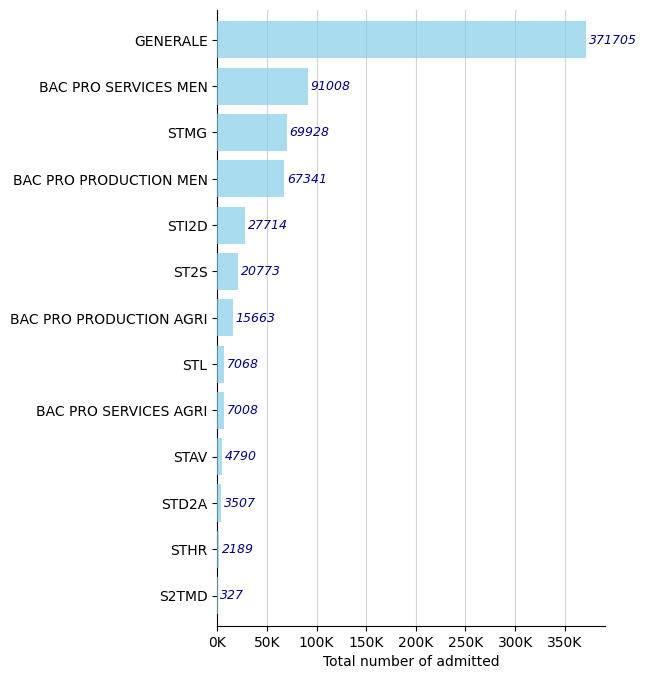

In [4]:
# -- Set barplot graphical options
opts = dict( 
    kind='barh',
    width=0.8,
    figsize = (5,8),
    ylabel = '',
    xlabel = 'Total number of admitted',
    legend = False,
    color = 'skyblue',
    alpha = 0.7,
    zorder = 20
)


# -- Perform aggregation by `serie` and plot (method chaining process)
ax = ( 
    df
    .groupby('serie')
    .agg({'nombre_d_admis_totaux': np.sum})
    .sort_values('nombre_d_admis_totaux')
    .plot(y='nombre_d_admis_totaux', **opts)
)


# -- Custom axis and bar labels
ax.xaxis.set_major_formatter(plt.FuncFormatter(label_fmts['k']))
ax.bar_label(ax.containers[0], padding = 2, 
             color='navy', fontsize=9, fontstyle='italic')

# -- Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# -- Add background grid
ax.grid(axis='x', color='lightgrey', zorder=10)


## Success rate per academy

**Note**: let's assume that students who are absent to the baccalaureat exam automatically failed. So, the success rate of each academy can be calculated as follow: 

$$
\ \Large SR_{i} = \frac{P_{i}}{R_{i}}
$$

$
\begin{align}
\ \ where: \ & SR_{i} \ : \text{success rate} \\
             & R_{i} \ : \text{number of registred student} \\
             & P_{i} \ : \text{number of student who passed the exam} \\
             & i \ : \ \text{academy} \\
\end{align}
$


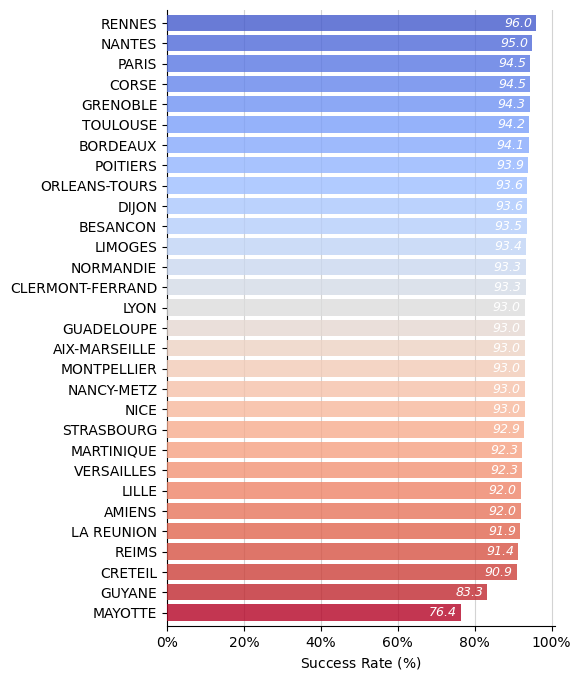

In [5]:
# Build normalized/graduate color for each bar
n_academy = len(df['academie'].unique())
cmap = plt.get_cmap('coolwarm_r')
norm = Normalize(vmin=0, vmax=n_academy)
colors = cmap(norm(list(range(n_academy))))

# -- Set barplot graphical options
opts = dict( 
    kind='barh',
    width=0.8,
    figsize = (5,8),
    ylabel = '',
    xlabel = 'Success Rate $(\%)$',
    legend = False,
    color = colors,
    alpha = 0.8,
    zorder = 20
)

# -- Perform aggregation by `academie` and plot (method chaining process)
ax = ( 
    df
    .rename(columns= {'nombre_d_inscrits' : 'R',
                      'nombre_d_admis_totaux' : 'P'})
    .groupby('academie')
    .agg({'R' : np.sum,'P' : np.sum})
    .assign(SR = lambda x: 100 * (x['P'].div(x['R'])))
    .round({'SR': 1})
    .sort_values('SR', ascending=True)
    .plot(y='SR', **opts)
)


# -- Custom axis and bar labels
ax.xaxis.set_major_formatter(plt.FuncFormatter(label_fmts['pct']))
ax.bar_label(ax.containers[0], 
             padding = -23, color='white', fmt='%.1f',
             fontsize=9, fontstyle='italic', zorder=30)

# -- Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# -- Add background grid
ax.grid(axis='x', color='lightgrey', zorder=10)

## Registered students parity

In [6]:
# -- Build chart on disk (Woman/man)
ax = (
    df
    .groupby('sexe')
    .agg({'nombre_d_inscrits' : np.sum})
    .pipe(plot_pie, column_name='nombre_d_inscrits', figsize= (4, 4))
)
# -- Save on disk
plt.margins(0,0)
ax.get_figure().savefig('assets/parity.png',
                        dpi=400, bbox_inches='tight')

# -- Close plot
plt.close()

In [7]:
# -- Set pie chart and external icons infos
data = [("assets/femme.png", '170px'),
        ("assets/parity.png", '330px'),
        ("assets/homme.png", '170px')]

# -- Build HTML string
title = "<h1 style='text-align: left; color: grey; margin-left: 150px;'>" \
        "Parity analyse in baccalaureat</h1><br><br>"

images=''.join(
    [f"<img style= 'width: {w};  float: left' src={s} />"
     for s, w in data])

# -- Show images 
display(HTML(title + images))